In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import plotnine as p9

In [12]:
hitters = pd.read_csv('/Users/oscarluo/Downloads/Hitters.csv')
hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [13]:
# Looking at missing data
hitters.isna().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [14]:
# Replace missing salary data with average
hitters['Salary'].fillna(hitters['Salary'].mean(), inplace=True)
hitters

<positron-console-cell-14>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,535.925882,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.000000,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.000000,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.000000,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.500000,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.000000,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.000000,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.000000,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.000000,A


# Part I: Different Model Specs

In [92]:
# Define X and y
X = hitters.drop("Salary", axis=1)
y = hitters["Salary"]

# CT
ct = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
         make_column_selector(dtype_include=object)),
        ("scale", StandardScaler(),
         make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

lr = LinearRegression()

# Create the linear regression pipeline
lr_pipeline = Pipeline([
    ("preprocessing", ct),
    ("lr", lr)
])

# Fit the pipeline to the full dataset
lr_pipeline.fit(X, y)

# Get coefficients
lr_coef = lr_pipeline.named_steps['lr'].coef_

# Get feature names from transformed data
cat_features = ct.named_transformers_["one_hot"].get_feature_names_out(input_features=X.select_dtypes(include=object).columns)
num_features = X.select_dtypes(include=np.number).columns
feature_names = np.concatenate([cat_features, num_features])

# Pair features with coefficients and most important ones by size
feature_coefficients = list(zip(feature_names, lr_coef))
sorted_coefficients = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)

# Display most significant coefficients
for feature, coef in sorted_coefficients[:10]:
    print(f"{feature}: {coef}")

CRuns: 429.1188810776027
AtBat: -310.8336994660927
CAtBat: -309.7234513025987
Hits: 286.9220505971286
CRBI: 210.89251515025924
CWalks: -177.75371266019405
Walks: 113.77095895125693
CHits: 92.0584551351487
PutOuts: 65.70063996330718
Division_W: -55.50379454676699
CRuns: 429.1188810776027
AtBat: -310.8336994660927
CAtBat: -309.7234513025987
Hits: 286.9220505971286
CRBI: 210.89251515025924
CWalks: -177.75371266019405
Walks: 113.77095895125693
CHits: 92.0584551351487
PutOuts: 65.70063996330718
Division_W: -55.50379454676699


Each run in a player’s career increases salary by about $429.12, which suggests that players who score more runs are highly valued.

Each at bat in the season decreases salary by approximately $310.83, which means that having a high number of at bats without standout performance might not contribute positively to salary.

Similar to AtBat, each career at bat reduces salary by about $310, which suggest that quantity alone doesn’t drive salary increases.

Each  hit in the season increases salary by about $286.92. This highlights the importance of effective batting performance in determining salary.

Each additional career RBI in a player’s career increases salary by about $210.89, showing that players with a track record of driving in runs tend to have higher salary.

In [55]:
# Cross-validation to estimate MSE
mse_scores = -cross_val_score(lr_pipeline, X, y, scoring="neg_mean_squared_error", cv=5)
mean_mse = np.mean(mse_scores)

print("Estimated Cross-Validated MSE:", mean_mse)

Estimated Cross-Validated MSE: 111079.9589401905
Estimated Cross-Validated MSE: 111079.9589401905


## B. Ridge regression

In [106]:
ridge = Ridge()

# Set up the Ridge regression pipeline
ridge_pipeline = Pipeline([
    ("preprocessing", ct),
    ("ridge_regression", ridge)
])

# Range of lambda values to search
alpha = {"ridge_regression__alpha": [0.001, 0.01, 0.1, 1, 10]}

# Perform grid search cross-validation
gscv_ridge = GridSearchCV(ridge_pipeline, alpha, cv=5, scoring="neg_mean_squared_error")
ridge_fitted = gscv_ridge.fit(X, y)

# Convert MSE scores to positive values for readability
positive_mse_scores = -ridge_fitted.cv_results_["mean_test_score"]

# Display alpha values and corresponding MSE scores
results_df = pd.DataFrame({
    "alphas": alpha["ridge_regression__alpha"],
    "scores": positive_mse_scores
})

print(results_df)

   alphas         scores
0   0.001  110827.268479
1   0.010  110706.903449
2   0.100  109843.994208
3   1.000  107961.775111
4  10.000  108447.788605
   alphas         scores
0   0.001  110827.268479
1   0.010  110706.903449
2   0.100  109843.994208
3   1.000  107961.775111
4  10.000  108447.788605


In [91]:
# Get best pipeline from grid search
best_ridge_model = ridge_fitted.best_estimator_

# Get coefficients from the Ridge regression model
ridge_coef = best_ridge_model.named_steps["ridge_regression"].coef_

# Ensure the correct transformer name is used to access categorical feature names
cat_features = best_ridge_model.named_steps["preprocessing"].named_transformers_["one_hot"].get_feature_names_out(
    input_features=X.select_dtypes(include=object).columns
)
num_features = X.select_dtypes(include=np.number).columns
variables = list(cat_features) + list(num_features)

# Create DataFrame to display feature names and coefficients
coef_df = pd.DataFrame({
    "Predictors": variables,
    "Coefficient": ridge_coef
})

# Sort coefficients by absolute value for importance
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

coef_df.head(10)

,Predictors,Coefficient
16,CRuns,308.502312
6,AtBat,-291.999497
7,Hits,254.470866
13,CAtBat,-192.812729
18,CWalks,-155.856907
17,CRBI,132.055392
14,CHits,128.640891
11,Walks,106.083069
12,Years,-67.889011
19,PutOuts,65.577334


For each career run, salary increases by about $308.50.

For each at-bat during the season, salary is decreased by $292.

For each hit in the season, it is associated with an increase in salary by around $254.47.

For each career at-bat, it is associated with a decrease in salary of about $193.81.

For each career walk, it is correlated with a decrease in salary by about $156.86.

In [97]:
# Get best cross-validated MSE from the grid search
print("Expected MSE for predicting 1989 salaries:", -ridge_fitted.best_score_)

Expected MSE for predicting 1989 salaries: 107961.77511144585
Expected MSE for predicting 1989 salaries: 107961.77511144585


## C. Lasso Regression

In [82]:
lasso = Lasso()

# Set up the Lasso regression pipeline
lasso_pipeline = Pipeline([
    ("preprocessing", ct),
    ("lasso_regression", lasso)
])

# Perform grid search cross-validation to find the best alpha
gscv_lasso = GridSearchCV(lasso_pipeline, alpha, cv=5, scoring="neg_mean_squared_error")
lasso_fitted = gscv_lasso.fit(X, y)

# Convert MSE scores to positive values for readability
positive_mse_scores = -lasso_fitted.cv_results_["mean_test_score"]

# Display alpha values and corresponding MSE scores
results_df = pd.DataFrame({
    "alphas": alpha["lasso_regression__alpha"],
    "scores": positive_mse_scores
})

print("Cross-Validation Results for Alpha Values in Lasso Regression:")
print(results_df)

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.180e+07, tolerance: 4.773e+03
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.065e+07, tolerance: 3.665e+03
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.198e+07, tolerance: 4.051e+03
/Applications/anaconda3/lib/python3.12/site

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.980e+06, tolerance: 4.314e+03
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.740e+06, tolerance: 4.496e+03
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.850e+04, tolerance: 4.773e+03
/Applications/anaconda3/lib/python3.12/site

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.495e+03, tolerance: 4.314e+03


Cross-Validation Results for Alpha Values in Lasso Regression:
   alphas         scores
0   0.001  110587.805496
1   0.010  110543.622361
2   0.100  110095.047688
3   1.000  108120.277446
4  10.000  112995.351102
Cross-Validation Results for Alpha Values in Lasso Regression:
   alphas         scores
0   0.001  110587.805496
1   0.010  110543.622361
2   0.100  110095.047688
3   1.000  108120.277446
4  10.000  112995.351102


In [89]:
cat_features = lasso_pipeline.named_steps["preprocessing"].named_transformers_["one_hot"].get_feature_names_out(
    input_features=X.select_dtypes(include=object).columns
)
num_features = X.select_dtypes(include=np.number).columns
var_names = list(cat_features) + list(num_features)

# Get the best model's coefficients
lasso_coef = lasso_fitted.best_estimator_.named_steps["lasso_regression"].coef_

# Create a DataFrame to display feature names and corresponding coefficients
coef_df = pd.DataFrame({
    "Predictors": var_names,
    "Coefficient": lasso_coef
})

# Sort coefficients by absolute value for importance
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

coef_df.head(10)

,Predictors,Coefficient
16,CRuns,322.919372
6,AtBat,-301.965077
7,Hits,268.257422
18,CWalks,-159.303481
17,CRBI,129.397762
2,Division_E,111.335545
11,Walks,103.905910
12,Years,-71.479936
13,CAtBat,-66.681811
19,PutOuts,65.935549


For each career run, salary increases by about $322.92.

For each at bat, salary decreases by -$301.97.

For each hit in the season, salary increases by $268.26

For each career walk, salary decreaes by -$159.30

For each career RBI, salary increases by $129.40


In [96]:
print("Expected MSE for predicting 1989 salaries:", -lasso_fitted.best_score_)

Expected MSE for predicting 1989 salaries: 108120.27744636913
Expected MSE for predicting 1989 salaries: 108120.27744636913


## D. Elastic Net

In [118]:
# Set up the Elastic Net pipeline
elastic_pipeline = Pipeline(
    [("preprocessing", ct),
     ("elastic_net", ElasticNet(max_iter=10000))]
).set_output(transform="pandas")

# Define lambda and l1_ratio
alphas = {
    "elastic_net__alpha": [0.001, 0.01, 0.1, 1, 10],
    "elastic_net__l1_ratio": [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
}

# Perform grid search cross-validation
gscv_elastic = GridSearchCV(elastic_net_regression, alphas, cv=5, scoring="neg_mean_squared_error")
elastic_fitted = gscv_elastic.fit(X, y)

# Convert MSE scores to positive values for readability
positive_mse_scores = -elastic_fitted.cv_results_["mean_test_score"]

# Display alpha and l1_ratio with corresponding MSE scores
results_df = pd.DataFrame({
    "alpha": elastic_fitted.cv_results_["param_elastic_net__alpha"],
    "l1_ratio": elastic_fitted.cv_results_["param_elastic_net__l1_ratio"],
    "MSE": positive_mse_scores
})

results_df

,alpha,l1_ratio,MSE
0,0.001,0.01,109065.903872
1,0.001,0.05,109102.918082
2,0.001,0.1,109151.297555
3,0.001,0.3,109372.345404
4,0.001,0.5,109650.866038
5,0.001,0.7,110013.253075
6,0.001,0.9,110509.504781
7,0.001,0.95,110663.988730
8,0.001,0.99,110798.979559
9,0.01,0.01,107620.139087


In [123]:
# Get best parameters and fit the pipeline with optimized hyperparameters
best_alpha = elastic_fitted.best_params_["elastic_net__alpha"]
best_l1_ratio = elastic_fitted.best_params_["elastic_net__l1_ratio"]

elastic_pipeline.set_params(
    elastic_net__alpha=best_alpha,
    elastic_net__l1_ratio=best_l1_ratio
)
elastic_pipeline.fit(X, y)

# Retrieve feature names and coefficients from the best model
cat_features = elastic_pipeline.named_steps["preprocessing"].named_transformers_["one_hot"].get_feature_names_out(
    input_features=X.select_dtypes(include=object).columns
)
num_features = X.select_dtypes(include=np.number).columns
variables = list(cat_features) + list(num_features)
elastic_net_coef = elastic_pipeline.named_steps["elastic_net"].coef_

# Display most significant coefficients
coef_df = pd.DataFrame({
    "Predictors": variables,
    "Coefficient": elastic_net_coef
})

# Sort coefficients by absolute value for significance
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

coef_df.head(10)

,Predictors,Coefficient
6,AtBat,-220.715293
7,Hits,190.588113
16,CRuns,181.655518
18,CWalks,-110.208856
11,Walks,87.602756
17,CRBI,82.882795
14,CHits,79.361123
12,Years,-77.460591
19,PutOuts,63.822676
3,Division_W,-57.211874


For each at bat, salary decreases by -$220.72

For each hit during the season, salary increases by $190.59

For each career runs, salary increases by $181.66

For each career walks, salary decreases by -$110.21

For each walks during the season, salary increases by $87.60

In [126]:
# MSE for predicting 1989 salaries
print("Expected MSE for predicting 1989 salaries with Elastic Net:", -elastic_fitted.best_score_)

Expected MSE for predicting 1989 salaries with Elastic Net: 107546.19349237923
Expected MSE for predicting 1989 salaries with Elastic Net: 107546.19349237923


# Part II. Variable Selection
Based on the above results, decide on:

Which numeric variable is most important.
CRuns

Which five numeric variables are most important
CRuns, AtBat, CAtBat, Hits, CRBI

Which categorical variable is most important
Division

For each of the four model specifications, compare the following possible feature sets:

Using only the one best numeric variable.

Using only the five best variables.

Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note: $\lambda$ and $\alpha$ must be re-tuned for each feature set.)

In [275]:
# Define Column Transformer for Dummies and Scaling
def create_column_transformer():
    return ColumnTransformer([
        ("one_hot", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
        ("scale", StandardScaler(), make_column_selector(dtype_include=np.number))
    ], remainder="passthrough").set_output(transform="pandas")

# Interaction Transformer based on feature data
def create_interaction_transformer(feature_data):
    interaction_columns = {
        'Hits': 'scale__Hits', 
        'PutOuts': 'scale__PutOuts', 
        'Walks': 'scale__Walks', 
        'CRBI': 'scale__CRBI', 
        'CRuns': 'scale__CRuns',
        'Division_E': 'one_hot__Division_E'
    }
    
    available_interactions = [
        (name, PolynomialFeatures(interaction_only=True, include_bias=False), [interaction_columns[col] for col in cols])
        for name, cols in {
            'hits_division': ['Hits', 'Division_E'],
            'putouts_division': ['PutOuts', 'Division_E'],
            'walks_division': ['Walks', 'Division_E'],
            'crbi_division': ['CRBI', 'Division_E'],
            'cruns_division': ['CRuns', 'Division_E']
        }.items() if all(col in feature_data.columns for col in cols)
    ]
    
    return ColumnTransformer(available_interactions, remainder="passthrough").set_output(transform="pandas")

# Base column transformer
ct = create_column_transformer()

# Function to calculate MSE
def get_mse(model, feature_data, target, alpha=None, l1_ratio=None):
    # Set alpha or lambda if provided
    if isinstance(model, Ridge) or isinstance(model, Lasso):
        model.set_params(alpha=alpha)
    elif isinstance(model, ElasticNet):
        model.set_params(alpha=alpha, l1_ratio=l1_ratio)

    pipeline = Pipeline([("preprocess", ct), ("model", model)])
    
    # Calculate and return MSE from cross-validation
    mse_scores = cross_val_score(pipeline, feature_data, target, cv=5, scoring="neg_mean_squared_error")
    mse = -mse_scores.mean()
    print(f"Cross-validated MSE for {model.__class__.__name__}: {mse}")
    return mse

# Function for Hyperparameter Tuning with Interactions
def tune_with_interactions(model, feature_data, target):
    # Set up the interaction transformer if multiple features
    if feature_data.shape[1] > 1:
        interaction_transformer = create_interaction_transformer(feature_data)
        pipeline = Pipeline([
            ("preprocess", ct),
            ("interactions", interaction_transformer),
            ("model", model)
        ])
    else:
        pipeline = Pipeline([
            ("preprocess", ct),
            ("model", model)
        ])
    
    # Define separate grids for each model type
    if isinstance(model, ElasticNet):
        param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1, 10], 'model__l1_ratio': [0.1, 0.5, 0.9]}
    else:
        param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1, 10]}

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
    grid_search.fit(feature_data, target)

    # Extract best parameters
    best_params = {
        "alpha": grid_search.best_params_['model__alpha'],
        "l1_ratio": grid_search.best_params_.get('model__l1_ratio', None)
    }
    best_score = grid_search.best_score_
    print(f"Tuned results for {model.__class__.__name__}: Alpha: {best_params['alpha']}, L1 Ratio: {best_params['l1_ratio']}, R2: {best_score}")
    return best_params

## Linear

In [276]:
# Best numeric variable as predictor

# Specifying X 
X = hitters[['CRuns']]  

# Calculate MSE for Linear Regression using the best numeric variable
get_mse(LinearRegression(), feature_data=X, target=y)

Cross-validated MSE for LinearRegression: 126308.142061745
Cross-validated MSE for LinearRegression: 126308.142061745


126308.142061745

In [262]:
# 5 best numeric variable as predictor

# Specifying X
X = hitters[['CRuns', 'AtBat', 'CAtBat', 'Hits', 'CRBI']]  

# Calculate MSE for Linear Regression using the best numeric variable
get_mse(LinearRegression(), feature_data=X, target=y)

Cross-validated MSE for LinearRegression: 110613.63340859996
Cross-validated MSE for LinearRegression: 110613.63340859996


110613.63340859996

In [263]:
# 5 best numeric variables and interactions with best categorical variable

X = hitters[['CRuns','CRBI', 'Hits', 'PutOuts', 'Walks','Division']]

get_mse(LinearRegression(), feature_data=X, target=y)

Cross-validated MSE for LinearRegression: 111083.23832786758
Cross-validated MSE for LinearRegression: 111083.23832786758


111083.23832786758

## Ridge

In [277]:
# Best numeric variable as predictor

X = hitters[['CRuns']]  

# Tuning for Feature Set
best_lambda = float(tune_with_interactions(Ridge(), feature_data=X, target=y)['alpha'])
print("Best Lambda Value:", best_lambda)

# Calculate MSE using the best lambda value
get_mse(Ridge(), feature_data=X, target=y, alpha=best_lambda)

Tuned results for Ridge: Alpha: 10, L1 Ratio: None, R2: 0.2319901518881867
Best Lambda Value: 10.0
Cross-validated MSE for Ridge: 126265.14518438917
Tuned results for Ridge: Alpha: 10, L1 Ratio: None, R2: 0.2319901518881867
Best Lambda Value: 10.0
Cross-validated MSE for Ridge: 126265.14518438917


126265.14518438917

In [278]:
# 5 best numeric variables

X = hitters[['CRuns', 'AtBat', 'CAtBat', 'Hits', 'CRBI']]  

# Tuning for Feature Set
best_lambda = float(tune_with_interactions(Ridge(), feature_data=X, target=y)['alpha'])
print("Best Lambda Value:", best_lambda)

# Calculate MSE using the best lambda value
get_mse(Ridge(), feature_data=X, target=y, alpha=best_lambda)

Tuned results for Ridge: Alpha: 1, L1 Ratio: None, R2: 0.3081315321451029
Best Lambda Value: 1.0
Cross-validated MSE for Ridge: 110629.01564902542
Tuned results for Ridge: Alpha: 1, L1 Ratio: None, R2: 0.3081315321451029
Best Lambda Value: 1.0
Cross-validated MSE for Ridge: 110629.01564902542


110629.01564902542

In [279]:
# 5 best numeric variables and interactions with best categorical variable

X = hitters[['CRuns', 'AtBat', 'CAtBat', 'Hits', 'CRBI', 'Division']]  

# Tuning for Feature Set
best_lambda = float(tune_with_interactions(Ridge(), feature_data=X, target=y)['alpha'])
print("Best Lambda Value:", best_lambda)

# Calculate MSE using the best lambda value
get_mse(Ridge(), feature_data=X, target=y, alpha=best_lambda)

Tuned results for Ridge: Alpha: 1, L1 Ratio: None, R2: 0.31028339381417425
Best Lambda Value: 1.0
Cross-validated MSE for Ridge: 108535.39377820064
Tuned results for Ridge: Alpha: 1, L1 Ratio: None, R2: 0.31028339381417425
Best Lambda Value: 1.0
Cross-validated MSE for Ridge: 108535.39377820064


108535.39377820064

## Lasso

In [310]:
# Function to calculate MSE with preprocessed data
def get_mse(model, X_transformed, y, alpha=None):
    if alpha is not None:
        model.set_params(alpha=alpha)
    pipeline = Pipeline([("model", model)])
    mse_scores = cross_val_score(pipeline, X_transformed, y, cv=5, scoring="neg_mean_squared_error")
    mse = -mse_scores.mean()
    print(f"Cross-validated MSE for {model.__class__.__name__}: {mse}")
    return mse

# Tuning function for Lasso model with preprocessed data
def tune_with_lasso(model, X_transformed, y):
    pipeline = Pipeline([("model", model)])
    param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1, 10]}
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_transformed, y)
    best_alpha = grid_search.best_params_['model__alpha']
    print(f"Best Alpha for Lasso: {best_alpha}, R2: {grid_search.best_score_}")
    return best_alpha

In [311]:
# Best numeric variable as predictor

X = hitters[['CRuns']]  

# Tuning for Feature Set
best_lambda = tune_with_lasso(Lasso(), X_transformed, y)
get_mse(Lasso(alpha=best_lambda), X_transformed, y)

Best Alpha for Lasso: 0.1, R2: 0.3092802178087622
Cross-validated MSE for Lasso: 108525.46164164218
Best Alpha for Lasso: 0.1, R2: 0.3092802178087622
Cross-validated MSE for Lasso: 108525.46164164218


108525.46164164218

In [312]:
# 5 best numeric variables 
X = hitters[['CRuns', 'AtBat', 'CAtBat', 'Hits', 'CRBI']]  

# Tuning for Feature Set
best_lambda = tune_with_lasso(Lasso(), X_transformed, y)
get_mse(Lasso(alpha=best_lambda), X_transformed, y)

Best Alpha for Lasso: 0.1, R2: 0.3092802178087622
Cross-validated MSE for Lasso: 108525.46164164218
Best Alpha for Lasso: 0.1, R2: 0.3092802178087622
Cross-validated MSE for Lasso: 108525.46164164218


108525.46164164218

In [313]:
# 5 best numeric variables and interactions with best categorical variable
X = hitters[['CRuns', 'AtBat', 'CAtBat', 'Hits', 'CRBI','Division']]  

# Tuning for Feature Set
best_lambda = tune_with_lasso(Lasso(), X_transformed, y)
get_mse(Lasso(alpha=best_lambda), X_transformed, y)

Best Alpha for Lasso: 0.1, R2: 0.3092802178087622
Cross-validated MSE for Lasso: 108525.46164164218
Best Alpha for Lasso: 0.1, R2: 0.3092802178087622
Cross-validated MSE for Lasso: 108525.46164164218


108525.46164164218

## Elastic Net

In [296]:
# Best numeric variable 
X = hitters[['CRuns']]

# Re-tuning with Feature Set
best_params = tune_with_interactions(ElasticNet(), feature_data=X, target=y)
best_lambda = best_params['alpha']
best_l1_ratio = best_params['l1_ratio']

print("Best Lambda Value (alpha):", best_lambda)
print("Best L1 Ratio:", best_l1_ratio)

# Calculate MSE using the best lambda (alpha) and l1_ratio
get_mse(ElasticNet(alpha=best_lambda, l1_ratio=best_l1_ratio), X, y)

Tuned results for ElasticNet: Alpha: 0.1, L1 Ratio: 0.1, R2: 0.23219409390951898
Best Lambda Value (alpha): 0.1
Best L1 Ratio: 0.1
Cross-validated MSE for ElasticNet: 126377.44450764442
Tuned results for ElasticNet: Alpha: 0.1, L1 Ratio: 0.1, R2: 0.23219409390951898
Best Lambda Value (alpha): 0.1
Best L1 Ratio: 0.1
Cross-validated MSE for ElasticNet: 126377.44450764442


126377.44450764442

In [295]:
# 5 best numeric variables 
X = hitters[['CRuns', 'AtBat', 'CAtBat', 'Hits', 'CRBI']]  

# Re-tuning with Feature Set
best_params = tune_with_interactions(ElasticNet(), feature_data=X, target=y)
best_lambda = best_params['alpha']
best_l1_ratio = best_params['l1_ratio']

print("Best Lambda Value (alpha):", best_lambda)
print("Best L1 Ratio:", best_l1_ratio)

# Calculate MSE using the best lambda (alpha) and l1_ratio
get_mse(ElasticNet(alpha=best_lambda, l1_ratio=best_l1_ratio), X, y)

Tuned results for ElasticNet: Alpha: 0.01, L1 Ratio: 0.5, R2: 0.308124825578613
Best Lambda Value (alpha): 0.01
Best L1 Ratio: 0.5
Cross-validated MSE for ElasticNet: 110697.9873733443
Tuned results for ElasticNet: Alpha: 0.01, L1 Ratio: 0.5, R2: 0.308124825578613
Best Lambda Value (alpha): 0.01
Best L1 Ratio: 0.5
Cross-validated MSE for ElasticNet: 110697.9873733443


110697.9873733443

In [294]:
# 5 best numeric variables and interactions with best categorical variable
X = hitters[['CRuns', 'AtBat', 'CAtBat', 'Hits', 'CRBI','Division']] 

# Re-tuning with Feature Set
best_params = tune_with_interactions(ElasticNet(), feature_data=X, target=y)
best_lambda = best_params['alpha']
best_l1_ratio = best_params['l1_ratio']

print("Best Lambda Value (alpha):", best_lambda)
print("Best L1 Ratio:", best_l1_ratio)

# Calculate MSE using the best lambda (alpha) and l1_ratio
get_mse(ElasticNet(alpha=best_lambda, l1_ratio=best_l1_ratio), X, y)

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e+06, tolerance: 4.773e+03
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.013e+07, tolerance: 4.773e+03
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.999e+06, tolerance: 3.665e+03
/Applications/anaconda3/lib/python3.12/site

Tuned results for ElasticNet: Alpha: 0.01, L1 Ratio: 0.5, R2: 0.310175472229846
Best Lambda Value (alpha): 0.01
Best L1 Ratio: 0.5
Cross-validated MSE for ElasticNet: 108595.47006031669
Tuned results for ElasticNet: Alpha: 0.01, L1 Ratio: 0.5, R2: 0.310175472229846
Best Lambda Value (alpha): 0.01
Best L1 Ratio: 0.5
Cross-validated MSE for ElasticNet: 108595.47006031669


108595.47006031669

Lasso with the 5 best numeric variables and the interaction with the best categorical variable performed the best because it has the lowest MSE of 108524.76569799737

# Part III. Discussion

## A. Ridge
Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

Ridge models have smaller coefficients compared to linear regression models. This makes sense because Ridge regression includes a penalty on the size of the coefficients.

## B. LASSO
Compare your LASSO model in I with your three LASSO models in II. Did you get the same $\lambda$ results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

Yes $\lambda$ are all the same. This makes sense because because we used a consistent hyperparameter tuning process with cross-validation. However, the MSEs are slightly different because of the different amounts of variables.

## C. Elastic Net
Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

Elastic Net models always "wins" with the lowest MSE because it combines characteristics from both Ridge and LASSO models. This allows Elastic Net models to handle multicollinearity while selecting the most important predictors.

# Part IV: Final Model
Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

In [337]:
# Narrowing X down to True Best Predictors (Combination of Lasso and ElasticNet Coefficients)
X = hitters[['CRuns','CRBI', 'Hits', 'PutOuts', 'Walks','Division','CHits','Errors']]
y = hitters['Salary'].dropna()
X = X.loc[y.index]  # Ensure X matches y's non-NaN rows

# Elastic Net Interaction was Best Pipeline
best_params = tune_with_interactions(ElasticNet(), feature_data=X, target=y)
best_lambda = best_params['alpha']
best_l1_ratio = best_params['l1_ratio']

# Define and fit the final pipeline
elastic_pipeline = Pipeline([
    ("preprocessing", create_column_transformer()),  # Assuming create_column_transformer() is already defined
    ("elastic_net", ElasticNet(alpha=best_lambda, l1_ratio=best_l1_ratio))
])
elastic_pipeline.fit(X, y)

# Retrieve feature names and coefficients from the best model
cat_features = elastic_pipeline.named_steps["preprocessing"].named_transformers_["one_hot"].get_feature_names_out(
    input_features=X.select_dtypes(include=object).columns
)
num_features = X.select_dtypes(include=np.number).columns
variables = list(cat_features) + list(num_features)
elastic_net_coef = elastic_pipeline.named_steps["elastic_net"].coef_

# Display most significant coefficients
coef_df = pd.DataFrame({
    "Predictors": variables,
    "Coefficient": elastic_net_coef
})

# Sort coefficients by absolute value for significance
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

# Calculate and display MSE of the final model
y_pred = elastic_pipeline.predict(X)
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error (MSE):", mse)

# Display top 10 coefficients
print(coef_df.head(10))


/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.866e+06, tolerance: 4.773e+03
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.903e+05, tolerance: 3.665e+03
/Applications/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.486e+05, tolerance: 4.314e+03
/Applications/anaconda3/lib/python3.12/site

Tuned results for ElasticNet: Alpha: 1, L1 Ratio: 0.5, R2: 0.30438575498623055
Mean Squared Error (MSE): 103925.2188789196
   Predictors  Coefficient
3        CRBI    51.418093
2       CRuns    51.147212
4        Hits    50.438391
7       CHits    47.055698
6       Walks    46.931845
5     PutOuts    45.615099
1  Division_W   -32.357492
0  Division_E    32.357475
8      Errors   -11.047745
Tuned results for ElasticNet: Alpha: 1, L1 Ratio: 0.5, R2: 0.30438575498623055
Mean Squared Error (MSE): 103925.2188789196
   Predictors  Coefficient
3        CRBI    51.418093
2       CRuns    51.147212
4        Hits    50.438391
7       CHits    47.055698
6       Walks    46.931845
5     PutOuts    45.615099
1  Division_W   -32.357492
0  Division_E    32.357475
8      Errors   -11.047745


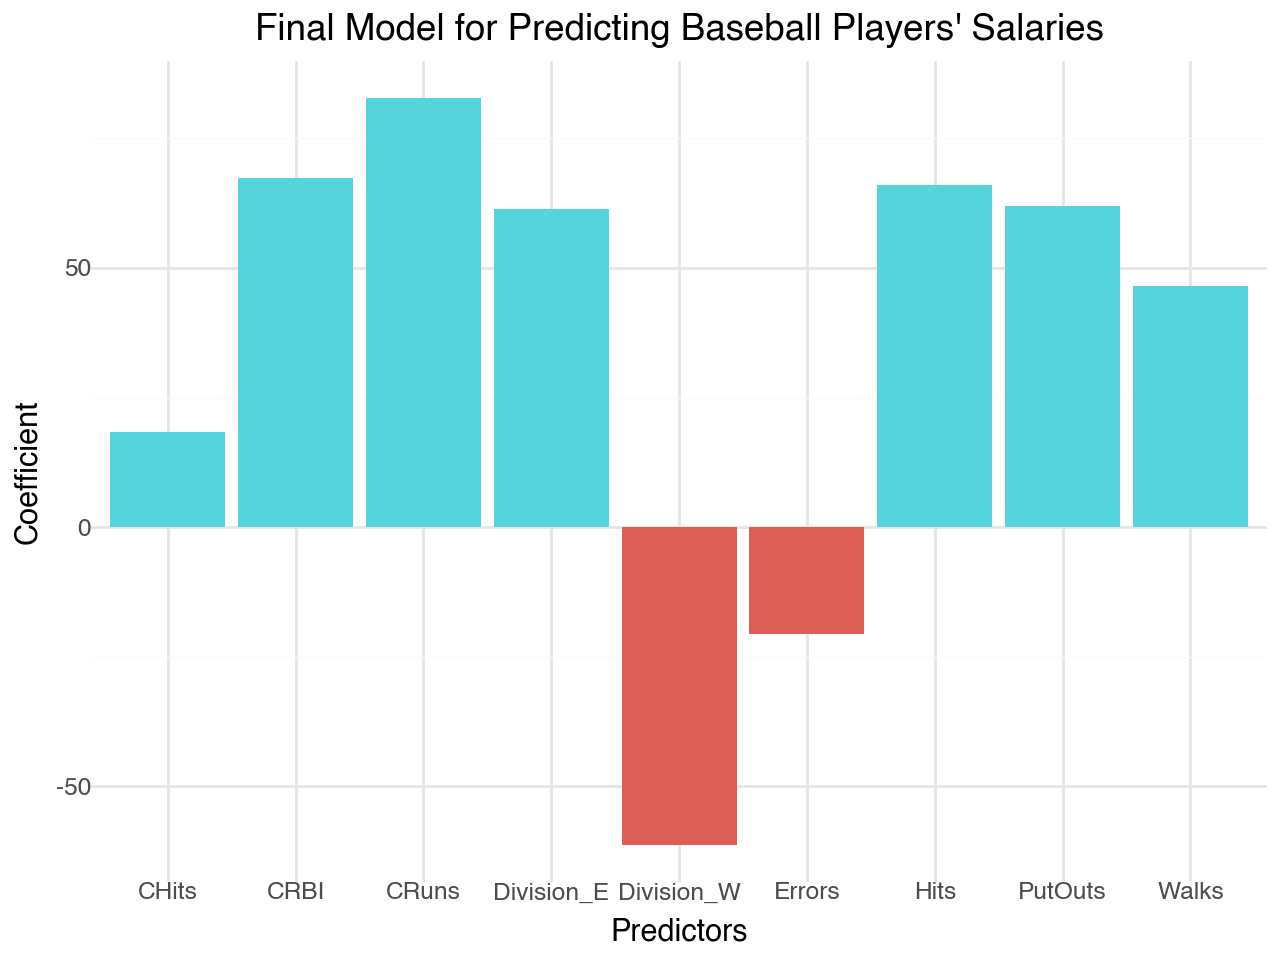

In [333]:
(
    p9.ggplot(coef_df, p9.aes(x="Predictors", y="Coefficient", fill="Coefficient > 0")) 
    + p9.geom_bar(stat="identity", show_legend=False) 
    + p9.labs(
        title="Final Model for Predicting Baseball Players' Salaries",
        x="Predictors",
        y="Coefficient")
    + p9.theme_minimal()
)

This plot shows the most significant predictors for predicting baseball player's salaries using a Elastic Net model. Increases in salary is shown in blue, while decreases are shown in red. It has a $\lambda$ of 1 and a MSE of 103925.22. The largest coefficients are CRBI and CRuns, and the smallest coefficients being Division_E and Division_W, which are the only two negative impact on salary.